# Exemple avancé : Données Sentinel-2 réelles

Ce notebook illustre l'utilisation de données satellite réelles Sentinel-2 depuis le **Microsoft Planetary Computer**.

**Niveau** : Avancé - Nécessite connexion Internet  
**Source** : Microsoft Planetary Computer (STAC API)  
**Librairies** : rasterio, pandas, matplotlib, seaborn, numpy, planetary-computer, pystac-client

**Explorer le catalogue** : https://planetarycomputer.microsoft.com/explore

# Exploration de données Sentinel-2 avec Planetary Computer

**Durée estimée** : 10-15 minutes  
**Prérequis** : Avoir complété [01a-validation-rapide.ipynb](01a-validation-rapide.ipynb)  
**Objectif** : Explorer des données satellite réelles et calculer l'indice NDVI sur une image Sentinel-2

**Connexion Internet requise** : Ce notebook télécharge des données depuis le cloud Microsoft.

---

## À propos de cet exemple

Ce notebook utilise le **Microsoft Planetary Computer**, une plateforme cloud donnant accès à des pétaoctets de données satellite gratuitement. Vous allez :

1. Vous connecter au catalogue STAC (SpatioTemporal Asset Catalog)
2. Charger une image Sentinel-2 réelle (4 bandes spectrales)
3. Calculer l'indice NDVI (Normalized Difference Vegetation Index)
4. Visualiser les résultats avec matplotlib

**Note technique** : Les données sont chargées directement depuis le cloud via des URLs signées - aucun téléchargement local permanent.

---

## Instructions

1. Exécutez chaque cellule séquentiellement avec **Shift+Enter**
2. La première connexion peut prendre 30-60 secondes (téléchargement depuis le cloud)
3. Si une erreur de connexion se produit, vérifiez votre accès Internet

**Résultat attendu** : Visualisations RGB et NDVI d'une image satellite réelle.

---

In [1]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import planetary_computer
from pystac_client import Client

## 1. Connexion Planetary Computer

Accès au catalogue STAC pour télécharger une image Sentinel-2 (Harmonized Landsat Sentinel).

In [ ]:
# Connexion au Planetary Computer avec gestion d'erreur
try:
    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace
    )
    print("Connexion au Planetary Computer réussie")
    
    # Récupérer un item Sentinel-2 spécifique
    # Note: Cet item était disponible en octobre 2025. Si cette cellule échoue,
    # l'item a peut-être été archivé. Consultez le catalogue pour trouver un nouvel item:
    # https://planetarycomputer.microsoft.com/explore
    item = catalog.get_collection("hls2-s30").get_item(
        "HLS.S30.T18TXS.2025289T155139.v2.0"
    )
    print(f"Item Sentinel-2 trouvé: {item.id}")
    
    # Extraire les URLs des bandes spectrales
    # B02=Bleu, B03=Vert, B04=Rouge, B08=NIR (Near Infrared)
    bands = {k: item.assets[k].href for k in ['B02', 'B03', 'B04', 'B08']}
    print(f"4 bandes spectrales récupérées")
    
except Exception as e:
    print("Erreur de connexion au Planetary Computer")
    print(f"   Erreur: {e}")
    print("\nVérifications suggérées:")
    print("   1. Votre connexion Internet est active")
    print("   2. Les librairies 'planetary-computer' et 'pystac-client' sont installées")
    print("   3. L'item STAC n'a pas été archivé (consultez le catalogue)")
    raise

## 2. Chargement bandes

Lecture des bandes spectrales (bleu, vert, rouge, NIR) avec masquage des valeurs invalides.

In [ ]:
# Chargement des bandes spectrales depuis le cloud
# Note: Cette étape peut prendre 30-60 secondes selon votre connexion

print("Chargement des bandes spectrales depuis le cloud...")
print("   (peut prendre 30-60 secondes)")

# Charger la bande bleue (B02) et extraire les métadonnées
with rasterio.open(bands['B02']) as src:
    blue = src.read(1)              # Lire la première (et unique) bande
    transform = src.transform       # Transformation affine (géoréférencement)
    crs = src.crs                   # Système de coordonnées (ex: EPSG:32618 pour UTM Zone 18N)
    nodata = src.nodata             # Valeur représentant pixels invalides (nuages, ombres)

print(f"Bande bleue chargée (B02)")

# Charger les autres bandes (réutilise les métadonnées de B02)
with rasterio.open(bands['B03']) as src:
    green = src.read(1)
print(f"Bande verte chargée (B03)")

with rasterio.open(bands['B04']) as src:
    red = src.read(1)
print(f"Bande rouge chargée (B04)")

with rasterio.open(bands['B08']) as src:
    nir = src.read(1)
print(f"Bande NIR chargée (B08)")

# Masquer les valeurs NoData (nuages, ombres, pixels hors zone)
# Créer un masque booléen : True = pixel valide, False = pixel à ignorer
mask = (blue != nodata) & (green != nodata) & (red != nodata) & (nir != nodata)

# Remplacer pixels invalides par NaN (Not a Number) pour calculs statistiques
blue_masked = np.where(mask, blue, np.nan)
green_masked = np.where(mask, green, np.nan)
red_masked = np.where(mask, red, np.nan)
nir_masked = np.where(mask, nir, np.nan)

print(f"\nToutes les bandes chargées et masquées")
print(f"   Dimensions: {red.shape[0]} × {red.shape[1]} pixels")
print(f"   Pixels valides: {np.sum(mask):,} / {mask.size:,} ({100*np.sum(mask)/mask.size:.1f}%)")

## 3. Statistiques pandas

In [4]:
stats = pd.DataFrame({
    'Bande': ['Bleu', 'Vert', 'Rouge', 'NIR'],
    'Min': [np.nanmin(blue_masked), np.nanmin(green_masked), np.nanmin(red_masked), np.nanmin(nir_masked)],
    'Max': [np.nanmax(blue_masked), np.nanmax(green_masked), np.nanmax(red_masked), np.nanmax(nir_masked)],
    'Moyenne': [np.nanmean(blue_masked), np.nanmean(green_masked), np.nanmean(red_masked), np.nanmean(nir_masked)]
}).round(1)

stats

,Bande,Min,Max,Moyenne
0,Bleu,-1762.0,7022.0,255.7
1,Vert,-1375.0,8002.0,466.3
2,Rouge,-908.0,8478.0,557.4
3,NIR,-508.0,9061.0,1799.0


## 4. Visualisation RGB

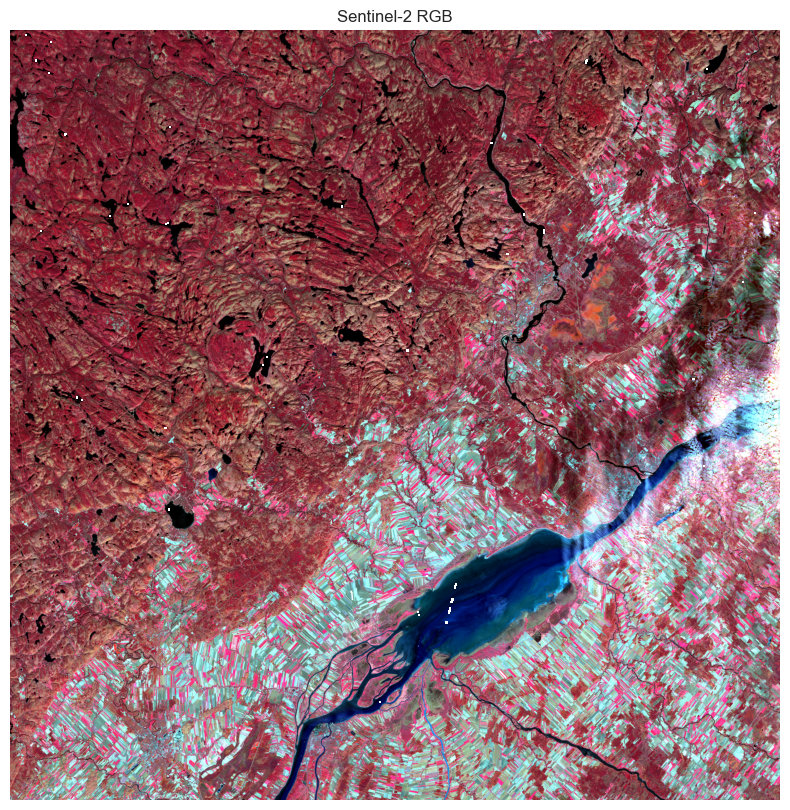

In [ ]:
# Normalisation
def norm(band):
    p2, p98 = np.nanpercentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

rgb = np.dstack([norm(nir_masked), norm(red_masked), norm(green_masked)])

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Sentinel-2 RGB')
plt.axis('off')
plt.show()

## 5. NDVI

Calcul de l'indice de végétation normalisé : NDVI = (NIR - Rouge) / (NIR + Rouge)

<positron-console-cell-6>:1: RuntimeWarning: divide by zero encountered in divide
<positron-console-cell-6>:1: RuntimeWarning: invalid value encountered in divide


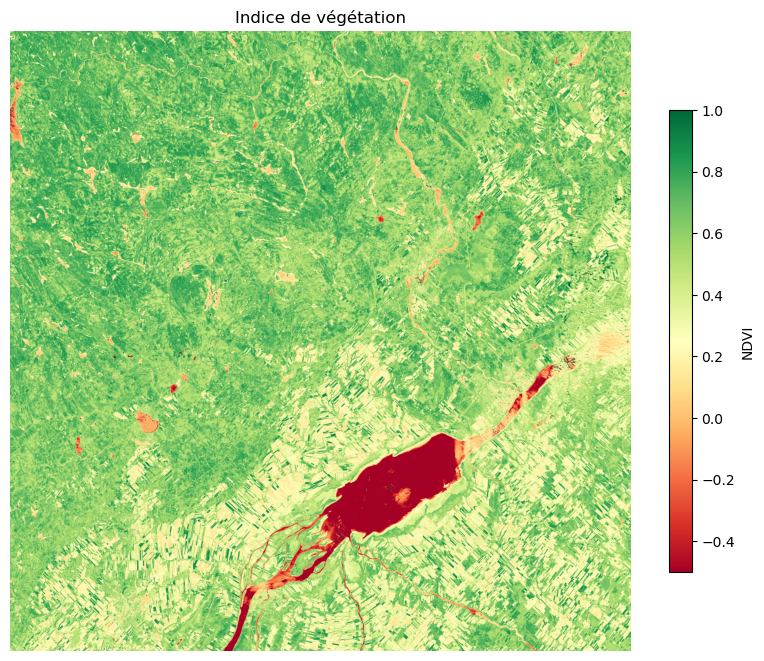

NDVI moyen: 0.508


In [6]:
ndvi = np.where((nir_masked + red_masked) == 0, np.nan, (nir_masked - red_masked) / (nir_masked + red_masked))

plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-0.5, vmax=1)
plt.colorbar(label='NDVI', shrink=0.6)
plt.title('Indice de végétation')
plt.axis('off')
plt.show()

print(f"NDVI moyen: {np.nanmean(ndvi):.3f}")

## 6. Distribution des bandes

Histogramme lissé (KDE) montrant la répartition des valeurs de réflectance pour chaque bande.

---

## Exemple complété avec succès

Si toutes les cellules ci-dessus se sont exécutées sans erreur, vous avez réussi à :

**Checklist d'accomplissement** :

- Vous connecter au Microsoft Planetary Computer (API STAC)
- Charger des données Sentinel-2 réelles depuis le cloud
- Manipuler des bandes spectrales multi-bandes avec rasterio
- Calculer l'indice NDVI sur données réelles
- Créer des visualisations cartographiques professionnelles
- Analyser la distribution spectrale avec seaborn

---

## Ce que vous avez appris

Cet exemple avancé vous a montré des compétences professionnelles en télédétection :

1. **Accès cloud-native** : Utiliser STAC pour découvrir et charger des données satellite
2. **Traitement multi-bandes** : Manipuler efficacement des images Sentinel-2
3. **Indices spectraux** : Calculer le NDVI (technique standard en télédétection)
4. **Visualisation scientifique** : Créer des cartes et graphiques publication-ready

**Applications réelles** : Ces techniques sont utilisées pour surveiller la déforestation, l'agriculture, les zones urbaines, les glaciers, etc.

---

## Pour aller plus loin

**Ressources avancées** :
- [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) - Catalogue complet de données
- [STAC Specification](https://stacspec.org/) - Standard pour données géospatiales cloud
- [Sentinel-2 User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi) - Documentation ESA

**Autres indices spectraux à explorer** :
- **NDWI** (Normalized Difference Water Index) : détection d'eau
- **NDBI** (Normalized Difference Built-up Index) : zones urbaines
- **EVI** (Enhanced Vegetation Index) : végétation dans régions denses

---

## Prochaine étape

**Pratique complète** : [02-pratique-projet-complet.md](02-pratique-projet-complet.md)  
Suivez un projet complet de A à Z incluant environnement Conda, VSCode, scripts Python, Git et GitHub (30 minutes).

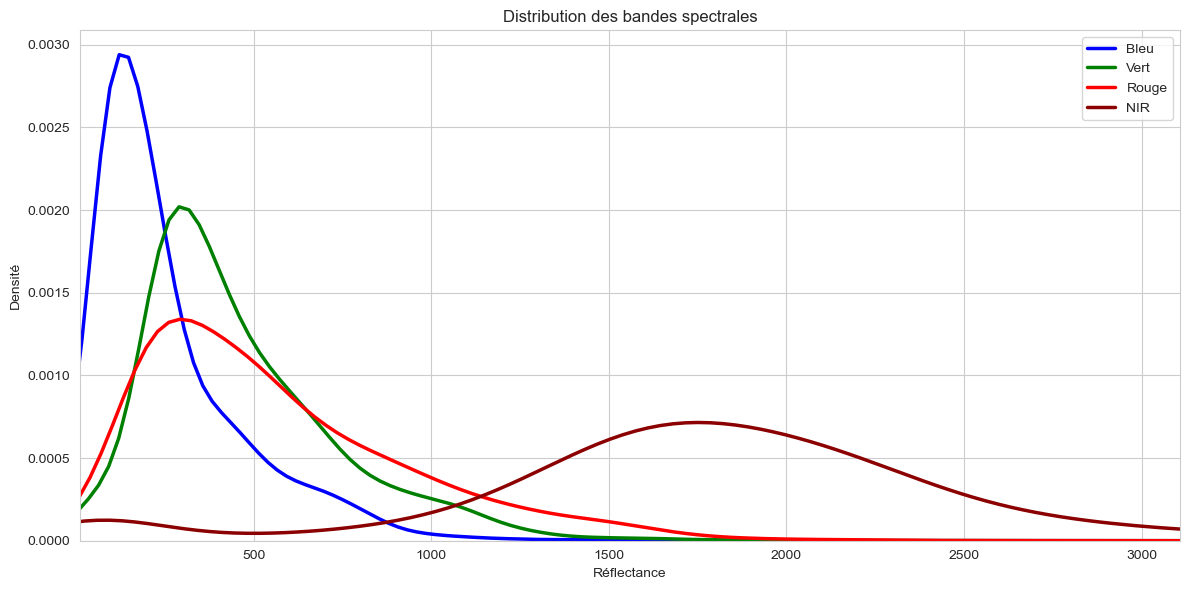

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Filtrer les NaN et sous-échantillonner
sample_size = 50000
blue_valid = blue_masked[~np.isnan(blue_masked)]
green_valid = green_masked[~np.isnan(green_masked)]
red_valid = red_masked[~np.isnan(red_masked)]
nir_valid = nir_masked[~np.isnan(nir_masked)]

blue_sample = np.random.choice(blue_valid, size=min(sample_size, blue_valid.size), replace=False)
green_sample = np.random.choice(green_valid, size=min(sample_size, green_valid.size), replace=False)
red_sample = np.random.choice(red_valid, size=min(sample_size, red_valid.size), replace=False)
nir_sample = np.random.choice(nir_valid, size=min(sample_size, nir_valid.size), replace=False)

sns.kdeplot(blue_sample, color='blue', linewidth=2.5, bw_adjust=2, label='Bleu')
sns.kdeplot(green_sample, color='green', linewidth=2.5, bw_adjust=2, label='Vert')
sns.kdeplot(red_sample, color='red', linewidth=2.5, bw_adjust=2, label='Rouge')
sns.kdeplot(nir_sample, color='darkred', linewidth=2.5, bw_adjust=2, label='NIR')

plt.xlim(np.percentile(np.concatenate([blue_sample, green_sample, red_sample, nir_sample]), [1, 99]))
plt.title('Distribution des bandes spectrales')
plt.xlabel('Réflectance')
plt.ylabel('Densité')
plt.legend()
plt.tight_layout()
plt.show()